* **Infinite Potential Well**

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_98671/1468955733.py:93: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  psi = spsolve(lhs_mat, known_vector)
/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_98671/1468955733.py:93: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  psi = spsolve(lhs_mat, known_vector)


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x600', '-pix_fmt', 'rgba', '-framerate', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '../simulation/infinite_wall_potential.mp4']' returned non-zero exit status 255.

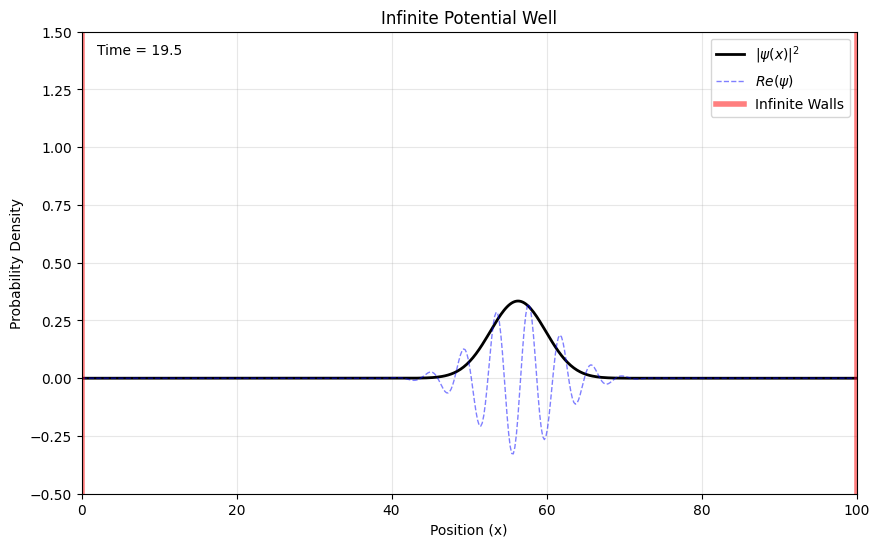

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib.animation import FuncAnimation

# 1. System setup (Atomic Units are set to unity hbar=1, m=1)

L = 100.0           # width of the well
N = 500             # number of grid points
dx = L / (N - 1)    # grid spacing
x = np.linspace(0, L, N)

# Time settings
dt = 0.1            # time step
t_max = 300         # total simulation time
steps = int(t_max / dt)

# 2. Potential and initial wavefunction

# Potential barrier
V = np.zeros(N)
# The ends of the grid (0 and N-1) become infinite walls

# Initial wavefunction (Gaussian wave packet)

x0 = L / 2          # initial position
k0 = 1.5            # initial momentum
sigma = 5.0         # width of the wave packet

# psi = (Gaussian envelope) * (plane wave)
psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)

# Exert boundary conditions (psi = 0 at the boundaries)
psi[0] = 0
psi[-1] = 0

# Normalization
norm = np.sqrt(np.sum(np.abs(psi)**2) * dx)
psi = psi / norm

# 3. Build Hamiltonian (Crank–Nicolson)
# Kinetic energy T = -1/2 * d^2/dx^2
coeff = -0.5 / dx**2
main_diag = -2 * coeff * np.ones(N)
off_diag  =  1 * coeff * np.ones(N-1)

# Add the potential on the diagonal
main_diag = main_diag + V
# Hamiltonian H (tridiagonal sparse matrix)
H = diags([main_diag, off_diag, off_diag], [0, -1, 1])

# Identity matrix I
I = diags([np.ones(N)], [0])

# 4. Crank–Nicolson operators
# (I + i*dt/2 * H) * psi_new = (I - i*dt/2 * H) * psi_old

# Left-hand-side matrix
lhs_mat = I + 1j * (dt / 2) * H

# Right-hand-side matrix
rhs_mat = I - 1j * (dt / 2) * H

# 5. Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, L)
ax.set_ylim(-0.5, 1.5)

line_prob, = ax.plot([], [], 'k-', lw=2, label=r'$|\psi(x)|^2$')
line_real, = ax.plot([], [], 'b--', lw=1, alpha=0.5, label=r'$Re(\psi)$')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Indication of the walls
ax.axvline(0, color='r', linewidth=4, alpha=0.5)
ax.axvline(L, color='r', linewidth=4, alpha=0.5, label='Infinite Walls')

ax.set_xlabel('Position (x)')
ax.set_ylabel('Probability Density')
ax.set_title('Infinite Potential Well')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# 6. Animation update function
def update(frame):
    global psi

    # For one time step of evolution,
    # Build right-hand side: b = (I - i*H*dt/2) * psi
    known_vector = rhs_mat.dot(psi)

    # Solve linear system: (I + i*H*dt/2) * psi_new = b
    psi = spsolve(lhs_mat, known_vector)

    # Enforce boundary conditions
    psi[0] = 0
    psi[-1] = 0

    # Update data
    prob = np.abs(psi)**2
    real_part = psi.real

    # Scale factors
    scale_factor = 3.0

    line_prob.set_data(x, prob * scale_factor)
    line_real.set_data(x, real_part)
    time_text.set_text(f'Time = {frame * dt:.1f}')

    return line_prob, line_real, time_text

anim = FuncAnimation(fig, update, frames=range(0, steps, 5), interval=30, blit=True)
anim.save('../simulation/infinite_wall_potential.mp4', fps=30)
plt.show()


* **Finite Potential Well**





/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_72481/1820589751.py:85: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  psi = spsolve(lhs_mat, known_vector)
/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_72481/1820589751.py:85: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  psi = spsolve(lhs_mat, known_vector)


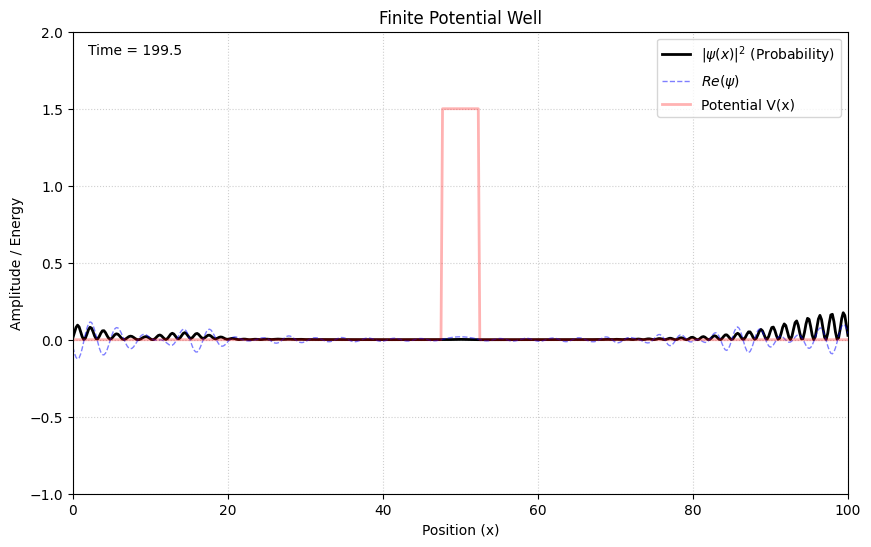

In [ ]:
# 1. System setup (Atomic Units are set to unity hbar=1, m=1)

L = 100.0           # width of the well
N = 500             # number of grid points
dx = L / (N - 1)    # grid spacing
x = np.linspace(0, L, N)

# Time settings
dt = 0.1            # time step
t_max = 200         # total simulation time
steps = int(t_max / dt)

# 2. Potential and initial wavefunction

# Potential barrier
V0 = 1.5            # barrier height
w = 5.0             # barrier width
center = L / 2      # barrier center position
V = np.zeros(N)
V[np.abs(x - center) < w/2] = V0  # place a rectangular barrier at the center

# Initial wavefunction (Gaussian wave packet)
x0 = L / 4          # initial position
k0 = 2.0            # initial momentum
sigma = 3.0         # width of the wave packet

# psi = (Gaussian envelope) * (plane wave)
psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)

# Normalization
norm = np.sqrt(np.sum(np.abs(psi)**2) * dx)
psi = psi / norm

# 3. Build the Hamiltonian (Crank–Nicolson)
# H = -1/2 * d^2/dx^2 + V(x)

# Kinetic energy T = -1/2 * d^2/dx^2
coeff = -0.5 / dx**2
main_diag = -2 * coeff * np.ones(N)
off_diag  =  1 * coeff * np.ones(N-1)

# Add the potential on the diagonal
main_diag = main_diag + V

# Hamiltonian H (tridiagonal sparse matrix)
H = diags([main_diag, off_diag, off_diag], [0, -1, 1])

# Identity matrix
I = diags([np.ones(N)], [0])

# 4. Crank–Nicolson operators
# (I + i*dt/2 * H) * psi_new = (I - i*dt/2 * H) * psi_old

# Left-hand-side matrix
lhs_mat = I + 1j * (dt / 2) * H

# Right-hand-side matrix
rhs_mat = I - 1j * (dt / 2) * H

# 5. Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, L)
ax.set_ylim(-1, 2.0)

line_prob, = ax.plot([], [], 'k-', lw=2, label=r'$|\psi(x)|^2$ (Probability)')
line_real, = ax.plot([], [], 'b--', lw=1, alpha=0.5, label=r'$Re(\psi)$')
line_V, = ax.plot(x, V, 'r-', lw=2, alpha=0.3, label='Potential V(x)')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.set_xlabel('Position (x)')
ax.set_ylabel('Amplitude / Energy')
ax.set_title('Finite Potential Well')
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.6)

# 6. Animation update function
def update(frame):
    global psi

    # For one time step of evolution,
    # Build right-hand side: b = (I - i*H*dt/2) * psi
    known_vector = rhs_mat.dot(psi)

    # Solve linear system: (I + i*H*dt/2) * psi_new = b
    psi = spsolve(lhs_mat, known_vector)

    # Update data
    prob = np.abs(psi)**2
    real_part = psi.real

    # Scale factors
    scale_factor = 1.5

    line_prob.set_data(x, prob * scale_factor)
    line_real.set_data(x, real_part * 0.5)  # reduce real-part amplitude
    time_text.set_text(f'Time = {frame * dt:.1f}')

    return line_prob, line_real, time_text

anim = FuncAnimation(fig, update, frames=range(0, steps, 5), interval=30, blit=True)
anim.save('../simulation/finite_wall_potential.mp4', fps=30)
plt.show()

* **Kronig-Penny Model**

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_72481/3510360259.py:99: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  psi = spsolve(lhs_mat, known_vector)
/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_72481/3510360259.py:99: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  psi = spsolve(lhs_mat, known_vector)


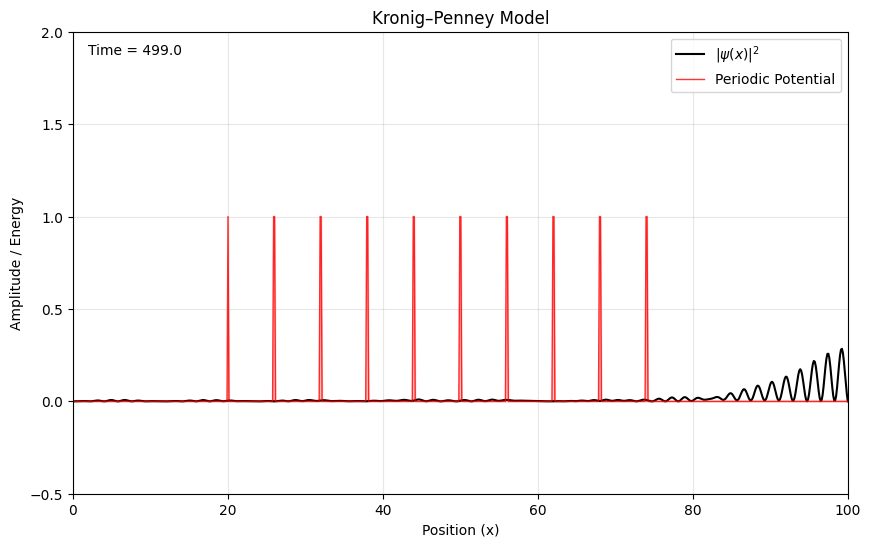

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib.animation import FuncAnimation

# 1. System setup
L = 100.0           # total length of the spatial domain
N = 800             # number of grid points
dx = L / (N - 1)
x = np.linspace(0, L, N)

# Time settings
dt = 0.1            # time step
t_max = 500         # total simulation time
steps = int(t_max / dt)

# 2. Potential and initial wavefunction

# Kronig–Penney potential (Periodic Potential)
V0 = 1.0            # barrier height
num_barriers = 10   # number of barriers
barrier_width = 0.2 # width of each barrier
lattice_const = 6.0 # lattice constant (spacing between barriers)

V = np.zeros(N)

# Place periodic barriers around the center of the domain
start_pos = L/2 - (num_barriers * lattice_const) / 2

for i in range(num_barriers):
    # Position of each barrier
    center = start_pos + i * lattice_const
    # Create the barrier around that position
    mask = np.abs(x - center) < barrier_width / 2
    V[mask] = V0

# Initial wavefunction (Gaussian Wave Packet)
x0 = L * 0.15       # initial position
k0 = 1.8            # initial momentum
sigma = 4.0         # wave packet width

# psi = (Gaussian envelope) * (plane wave)
psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)

# Exert boundary conditions (psi = 0 at the boundaries)
psi[0] = 0
psi[-1] = 0

# Normalization
norm = np.sqrt(np.sum(np.abs(psi)**2) * dx)
psi = psi / norm

# 3. Build the Hamiltonian (Crank–Nicolson)

# Kinetic energy operator: T = -1/2 * d^2/dx^2
coeff = -0.5 / dx**2
main_diag = -2 * coeff * np.ones(N)
off_diag  =  1 * coeff * np.ones(N-1)

# Add the potential on the diagonal
main_diag = main_diag + V

# Hamiltonian H (tridiagonal sparse matrix)
H = diags([main_diag, off_diag, off_diag], [0, -1, 1])

# Identity matrix
I = diags([np.ones(N)], [0])

# 4. Crank–Nicolson operators
lhs_mat = I + 1j * (dt / 2) * H
rhs_mat = I - 1j * (dt / 2) * H

# 5. Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, L)
ax.set_ylim(-0.5, 2.0)

line_prob, = ax.plot([], [], 'k-', lw=1.5, label=r'$|\psi(x)|^2$')
line_V, = ax.plot(x, V, 'r-', lw=1, alpha=0.8, label='Periodic Potential')
ax.fill_between(x, 0, V, color='red', alpha=0.2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.set_xlabel('Position (x)')
ax.set_ylabel('Amplitude / Energy')
ax.set_title('Kronig–Penney Model')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)


# 6. Animation update function
def update(frame):
    global psi

    # For one time step of evolution,
    # Build right-hand side: b = (I - i*H*dt/2) * psi
    known_vector = rhs_mat.dot(psi)
    # Solve linear system: (I + i*H*dt/2) * psi_new = b
    psi = spsolve(lhs_mat, known_vector)

    # Enforce boundary conditions
    psi[0] = 0
    psi[-1] = 0

    # Update data
    prob = np.abs(psi)**2

    # Visualization scaling
    scale_factor = 2.0

    line_prob.set_data(x, prob * scale_factor)
    time_text.set_text(f'Time = {frame * dt:.1f}')

    return line_prob, time_text

anim = FuncAnimation(fig, update, frames=range(0, steps, 10), interval=30, blit=True)
anim.save('../simulation/kronig_penney.mp4', fps=30)
plt.show()